Step 1- Import the required libraries 

In [0]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
sns.set()


In [0]:
# setting the number of cross validations to be used in model testing 
nr_cv = 5

# switch for using log values for SalePrice and features     
use_logvals = 1    
# target used for correlation 
target = 'SalePrice_Log'
    
# only columns with correlation above this threshold value  
# are used for the ML Regressors in Part 3
min_val_corr = 0.4
#0.4 is a random threshold and not a standard/fixed value. 
    
# switch for dropping columns that are similar to others already used and show a high correlation to these     
drop_similar = 1

In [0]:
def get_best_score(grid):
    
    best_score = np.sqrt(-grid.best_score_)
    print(best_score)    
    print(grid.best_params_)
    print(grid.best_estimator_)
    
    return best_score

In [0]:
def print_cols_large_corr(df, nr_c, targ) :
    corr = df.corr()
    corr_abs = corr.abs()
    print (corr_abs.nlargest(nr_c, targ)[targ])

In [0]:
def plot_corr_matrix(df, nr_c, targ) :
    
    corr = df.corr()
    corr_abs = corr.abs()
    cols = corr_abs.nlargest(nr_c, targ)[targ].index
    cm = np.corrcoef(df[cols].values.T)

    plt.figure(figsize=(nr_c/1.5, nr_c/1.5))
    sns.set(font_scale=1.25)
    sns.heatmap(cm, linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=cols.values, xticklabels=cols.values
               )
    plt.show()

Load the data

In [0]:
from google.colab import files

uploaded = files.upload()

Saving train.csv to train.csv


In [0]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

User uploaded file "train.csv" with length 460676 bytes


In [0]:
import io
df_train = pd.read_csv(io.StringIO(uploaded['train.csv'].decode('utf-8')))
print(df_train.head())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008     

In [0]:
uploaded = files.upload()

Saving test.csv to test.csv


In [0]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

User uploaded file "test.csv" with length 451405 bytes


In [0]:
df_test = pd.read_csv(io.StringIO(uploaded['test.csv'].decode('utf-8')))
print(df_test.head())

     Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities      ...       ScreenPorch PoolArea PoolQC  Fence  \
0         Lvl    AllPub      ...               120        0    NaN  MnPrv   
1         Lvl    AllPub      ...                 0        0    NaN    NaN   
2         Lvl    AllPub      ...                 0        0    NaN  MnPrv   
3         Lvl    AllPub      ...                 0        0    NaN    NaN   
4         HLS    AllPub      ...               144        0    NaN    NaN   

  MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  
0         NaN   

In [0]:
print(df_train.shape)
print("--"*25)
print(df_test.shape)

(1460, 81)
--------------------------------------------------
(1459, 80)


In [0]:
print(df_train.info())
print("--"*25)
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [0]:
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [0]:
df_test.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,...,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,...,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,...,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,...,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,...,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,...,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,...,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


Skewness: 1.882876
Kurtosis: 6.536282


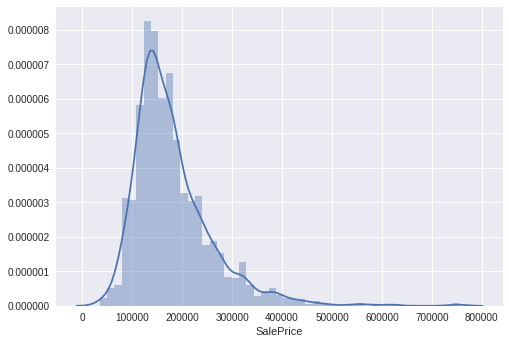

In [0]:
sns.distplot(df_train['SalePrice']);
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 0.121347
Kurtosis: 0.809519


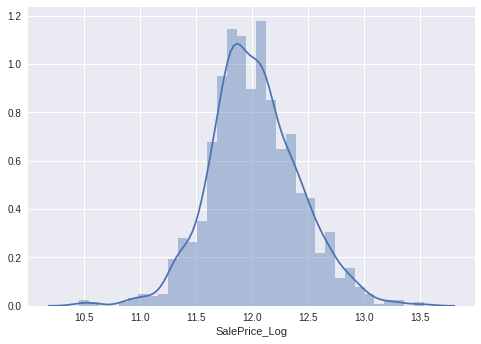

In [0]:
df_train['SalePrice_Log'] = np.log1p(df_train['SalePrice'])
sns.distplot(df_train['SalePrice_Log']);
print("Skewness: %f" % df_train['SalePrice_Log'].skew())
print("Kurtosis: %f" % df_train['SalePrice_Log'].kurt())
# dropping old column
df_train.drop('SalePrice', axis= 1, inplace=True)

In [0]:
numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index
print("# of Numerical features: ", len(numerical_feats))

categorical_feats = df_train.dtypes[df_train.dtypes == "object"].index
print("# of Categorical features: ", len(categorical_feats))

# of Numerical features:  38
# of Categorical features:  43


In [0]:
df_train[numerical_feats].head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice_Log
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,12.247699
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,12.109016
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,12.317171
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,11.849405
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,12.429220


In [0]:
df_train[categorical_feats].head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [0]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)


,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [0]:
# columns where NaN values are replaced with None.
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType', 'Electrical',
               'KitchenQual', 'SaleType', 'Functional', 'Exterior2nd', 'Exterior1st',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2',
               'MSZoning', 'Utilities']

# replace 'NaN' with 'None' in these columns
for col in cols_fillna:
    df_train[col].fillna('None',inplace=True)
    df_test[col].fillna('None',inplace=True)

In [0]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
MasVnrArea,8,0.005479
SalePrice_Log,0,0.000000
ExterCond,0,0.000000
RoofStyle,0,0.000000
RoofMatl,0,0.000000
Exterior1st,0,0.000000
Exterior2nd,0,0.000000
MasVnrType,0,0.000000


In [0]:
# for other variables replace missing with mean/mode
df_train.fillna(df_train.mean(), inplace=True)
df_test.fillna(df_test.mean(), inplace=True)
df_train.fillna(df_train.mode(), inplace=True)
df_test.fillna(df_test.mode(), inplace=True)

In [0]:
for col in numerical_feats:
    print(col)
    print("Skewness: %f" % df_train[col].skew())
    print("Kurtosis: %f" % df_train[col].kurt())
    print("--"*25)

Id
Skewness: 0.000000
Kurtosis: -1.200000
--------------------------------------------------
MSSubClass
Skewness: 1.407657
Kurtosis: 1.580188
--------------------------------------------------
LotFrontage
Skewness: 2.384950
Kurtosis: 21.848165
--------------------------------------------------
LotArea
Skewness: 12.207688
Kurtosis: 203.243271
--------------------------------------------------
OverallQual
Skewness: 0.216944
Kurtosis: 0.096293
--------------------------------------------------
OverallCond
Skewness: 0.693067
Kurtosis: 1.106413
--------------------------------------------------
YearBuilt
Skewness: -0.613461
Kurtosis: -0.439552
--------------------------------------------------
YearRemodAdd
Skewness: -0.503562
Kurtosis: -1.272245
--------------------------------------------------
MasVnrArea
Skewness: 2.676412
Kurtosis: 10.154316
--------------------------------------------------
BsmtFinSF1
Skewness: 1.685503
Kurtosis: 11.118236
-----------------------------------------------

Skewness: 1.366560
Kurtosis: 4.895121


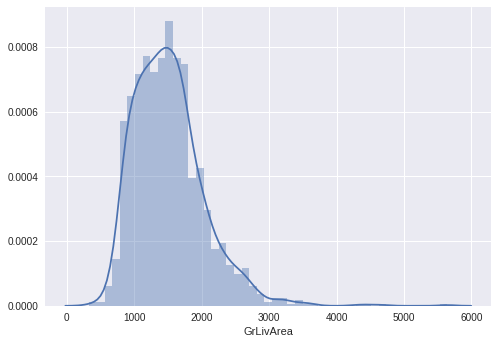

In [0]:
sns.distplot(df_train['GrLivArea']);
print("Skewness: %f" % df_train['GrLivArea'].skew())
print("Kurtosis: %f" % df_train['GrLivArea'].kurt())

Skewness: 12.207688
Kurtosis: 203.243271


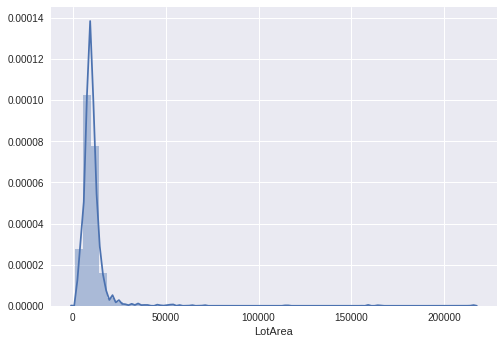

In [0]:
sns.distplot(df_train['LotArea']);
print("Skewness: %f" % df_train['LotArea'].skew())
print("Kurtosis: %f" % df_train['LotArea'].kurt())

In [0]:
for df in [df_train, df_test]:
    df['GrLivArea_Log'] = np.log(df['GrLivArea'])
    df.drop('GrLivArea', inplace= True, axis = 1)
    df['LotArea_Log'] = np.log(df['LotArea'])
    df.drop('LotArea', inplace= True, axis = 1)
    
    
    
numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index

Skewness: -0.006995
Kurtosis: 0.282603


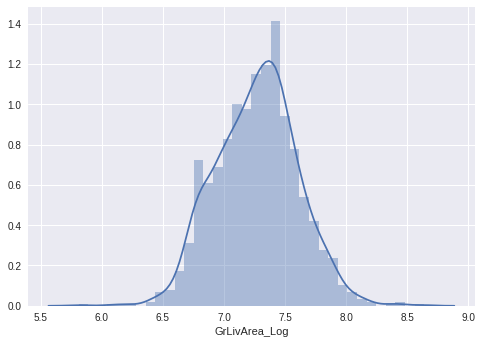

In [0]:
sns.distplot(df_train['GrLivArea_Log']);
print("Skewness: %f" % df_train['GrLivArea_Log'].skew())
print("Kurtosis: %f" % df_train['GrLivArea_Log'].kurt())

Skewness: -0.137994
Kurtosis: 4.713358


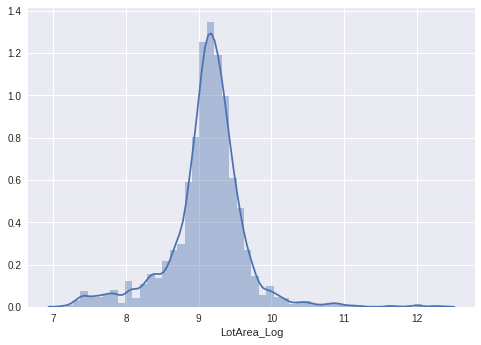

In [0]:
sns.distplot(df_train['LotArea_Log']);
print("Skewness: %f" % df_train['LotArea_Log'].skew())
print("Kurtosis: %f" % df_train['LotArea_Log'].kurt())

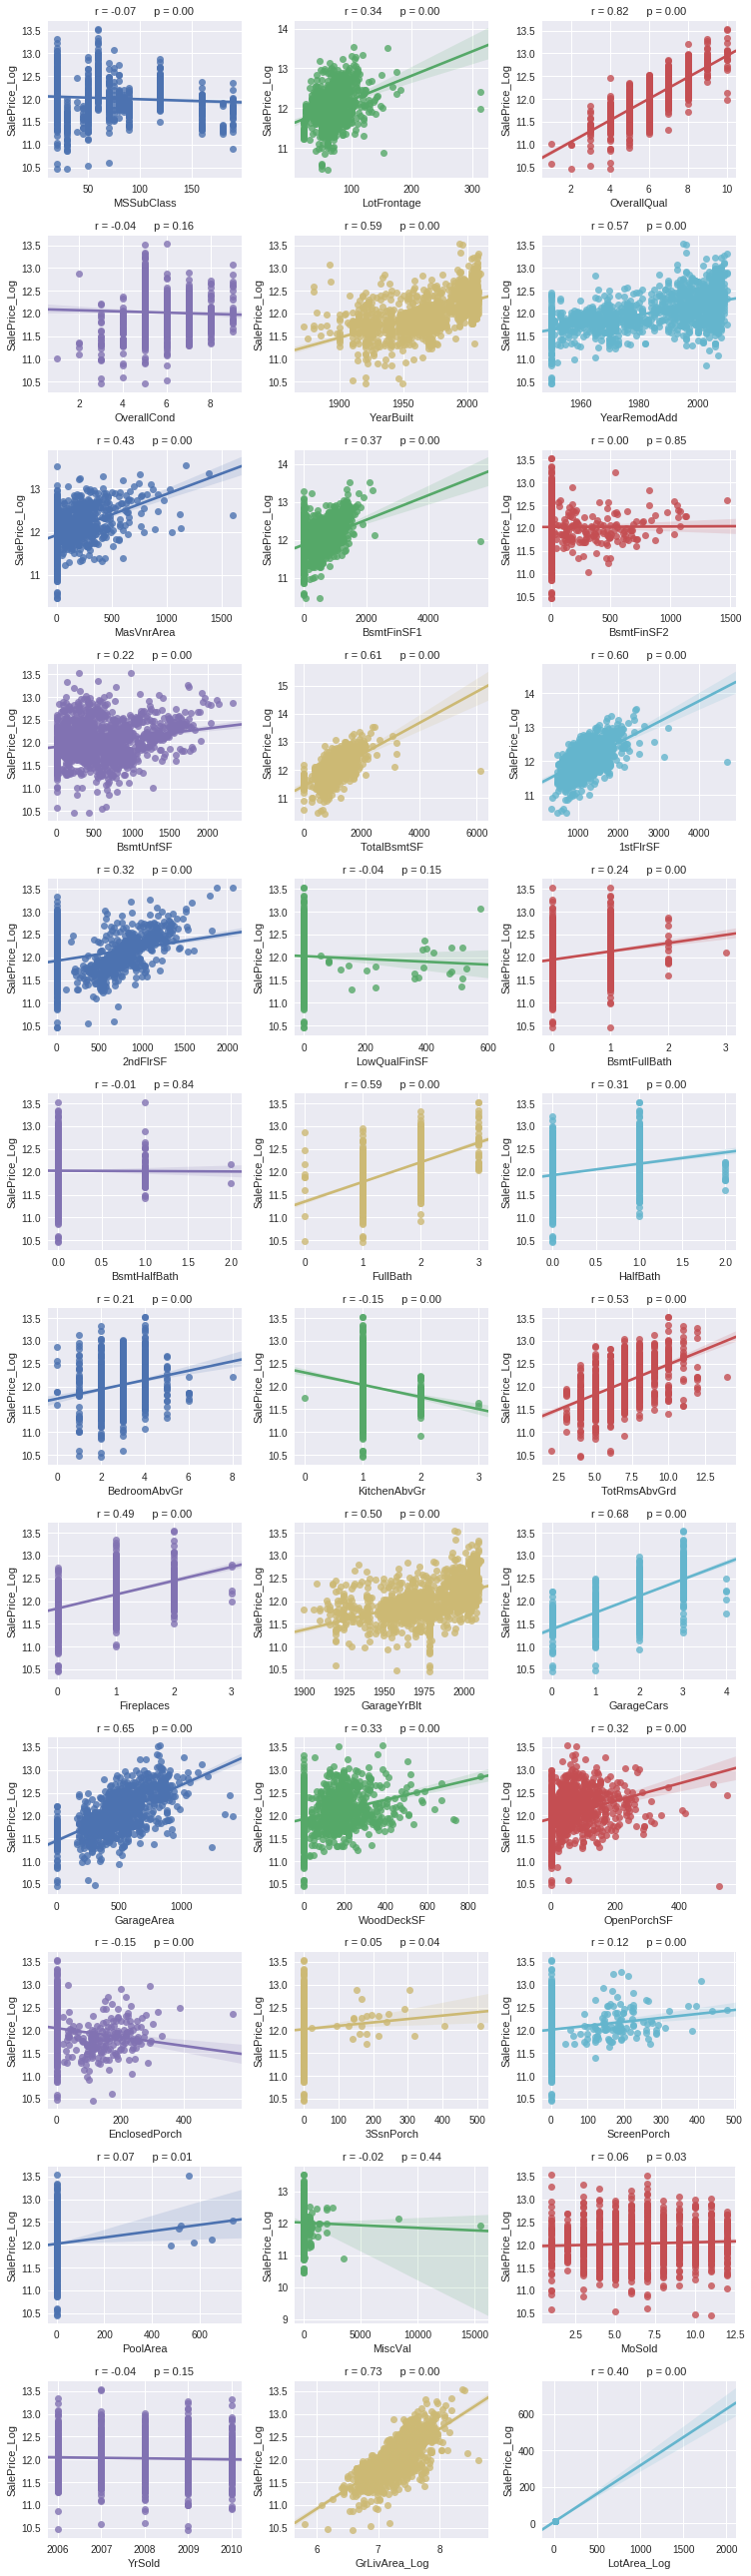

In [0]:
nr_rows = 12
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

li_num_feats = list(numerical_feats)
li_not_plot = ['Id', 'SalePrice', 'SalePrice_Log']
li_plot_num_feats = [c for c in list(numerical_feats) if c not in li_not_plot]


for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_plot_num_feats):
            sns.regplot(df_train[li_plot_num_feats[i]], df_train[target], ax = axs[r][c])
            stp = stats.pearsonr(df_train[li_plot_num_feats[i]], df_train[target])
            #axs[r][c].text(0.4,0.9,"title",fontsize=8)
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show()   

In [0]:
corr = df_train.corr()
corr_abs = corr.abs()

nr_num_cols = len(numerical_feats)
ser_corr = corr_abs.nlargest(nr_num_cols, target)[target]

cols_abv_corr_limit = list(ser_corr[ser_corr.values > min_val_corr].index)
cols_bel_corr_limit = list(ser_corr[ser_corr.values <= min_val_corr].index)

In [0]:
print(ser_corr)
print("--"*30)
print("List of numerical features with r above min_val_corr :")
print(cols_abv_corr_limit)
print("--"*30)
print("List of numerical features with r below min_val_corr :")
print(cols_bel_corr_limit)

SalePrice_Log    1.000000
OverallQual      0.817185
GrLivArea_Log    0.730255
GarageCars       0.680625
GarageArea       0.650888
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771
YearBuilt        0.586570
YearRemodAdd     0.565608
TotRmsAbvGrd     0.534422
GarageYrBlt      0.500449
Fireplaces       0.489450
MasVnrArea       0.429532
LotArea_Log      0.399918
BsmtFinSF1       0.372023
LotFrontage      0.336156
WoodDeckSF       0.334135
OpenPorchSF      0.321053
2ndFlrSF         0.319300
HalfBath         0.313982
BsmtFullBath     0.236224
BsmtUnfSF        0.221985
BedroomAbvGr     0.209043
EnclosedPorch    0.149050
KitchenAbvGr     0.147548
ScreenPorch      0.121208
MSSubClass       0.073959
PoolArea         0.069798
MoSold           0.057330
3SsnPorch        0.054900
LowQualFinSF     0.037963
YrSold           0.037263
OverallCond      0.036868
MiscVal          0.020021
Id               0.017942
BsmtHalfBath     0.005149
BsmtFinSF2       0.004832
Name: SalePr

In [0]:
for catg in list(categorical_feats) :
    print(df_train[catg].value_counts())
    print('--'*50)

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
----------------------------------------------------------------------------------------------------
Pave    1454
Grvl       6
Name: Street, dtype: int64
----------------------------------------------------------------------------------------------------
None    1369
Grvl      50
Pave      41
Name: Alley, dtype: int64
----------------------------------------------------------------------------------------------------
Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64
----------------------------------------------------------------------------------------------------
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64
----------------------------------------------------------------------------------------------------
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64
-------------------------------------------------------

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


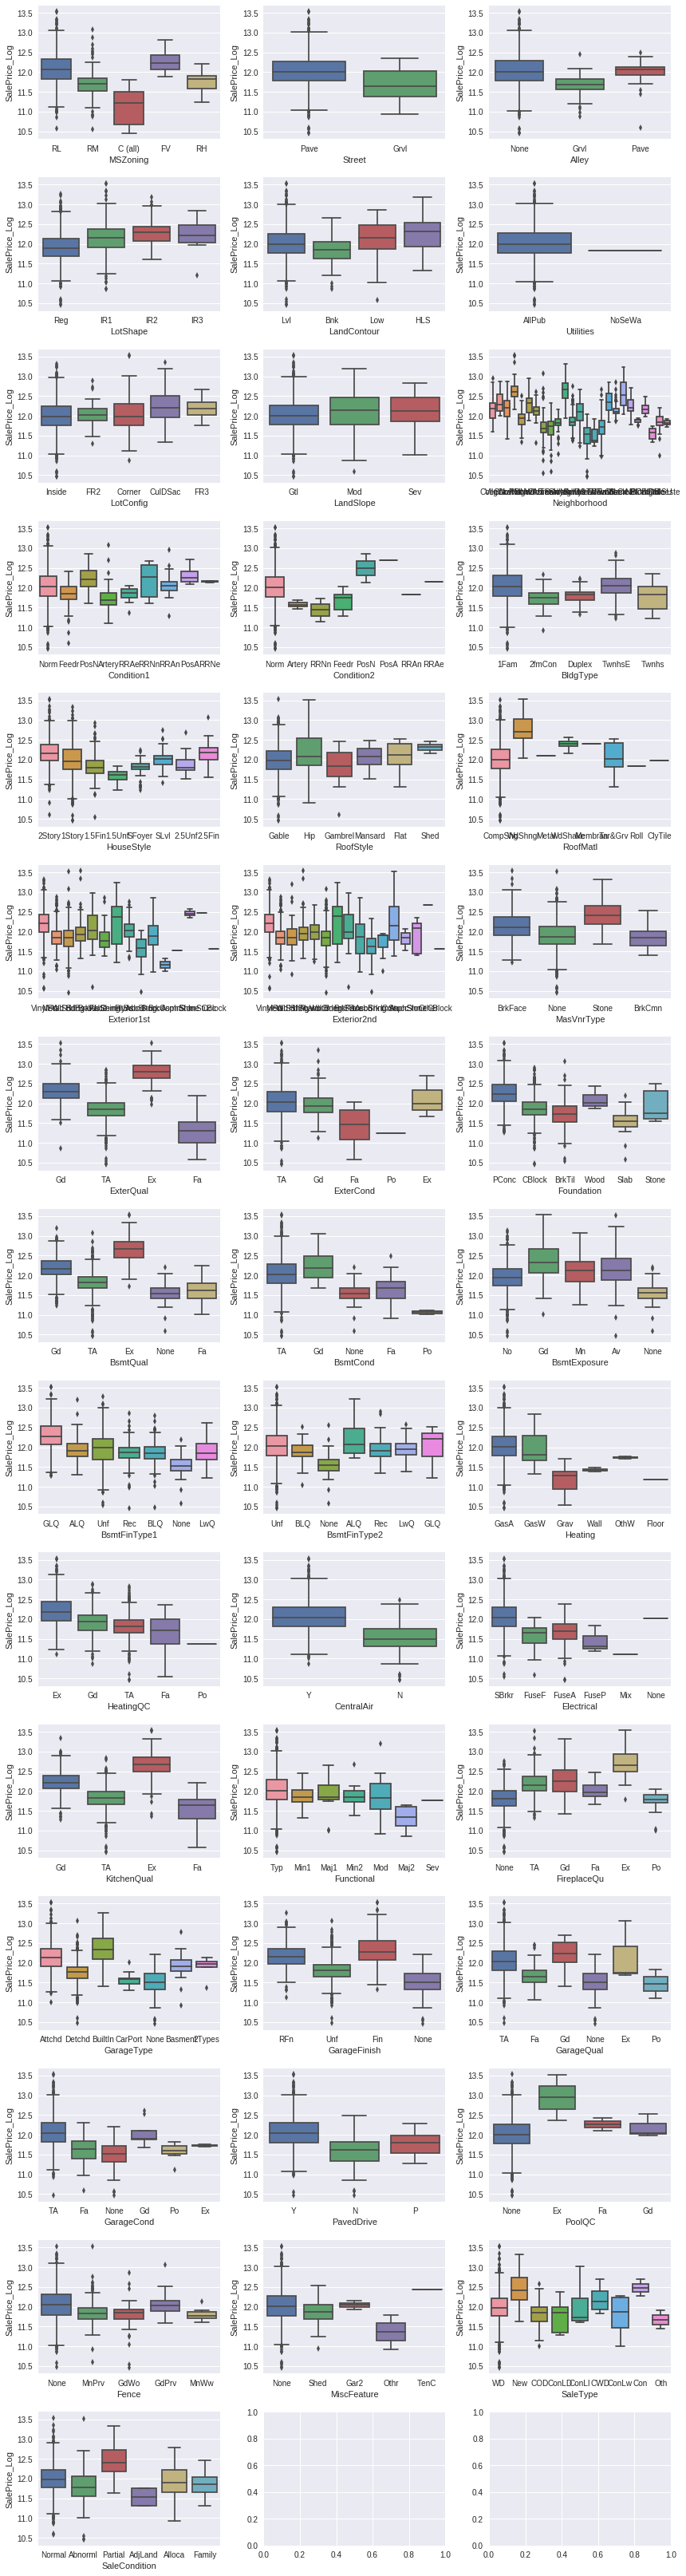

In [0]:
li_cat_feats = list(categorical_feats)
nr_rows = 15
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_cat_feats):
            sns.boxplot(x=li_cat_feats[i], y=target, data=df_train, ax = axs[r][c])
    
plt.tight_layout()    
plt.show() 

In [0]:
catg_strong_corr = [ 'MSZoning', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual', 
                     'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType']

catg_weak_corr = ['Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 
                  'LandSlope', 'Condition1',  'BldgType', 'HouseStyle', 'RoofStyle', 
                  'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterCond', 'Foundation', 
                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 
                  'HeatingQC', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 
                  'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 
                  'SaleCondition' ]

In [0]:
nr_feats = len(cols_abv_corr_limit)

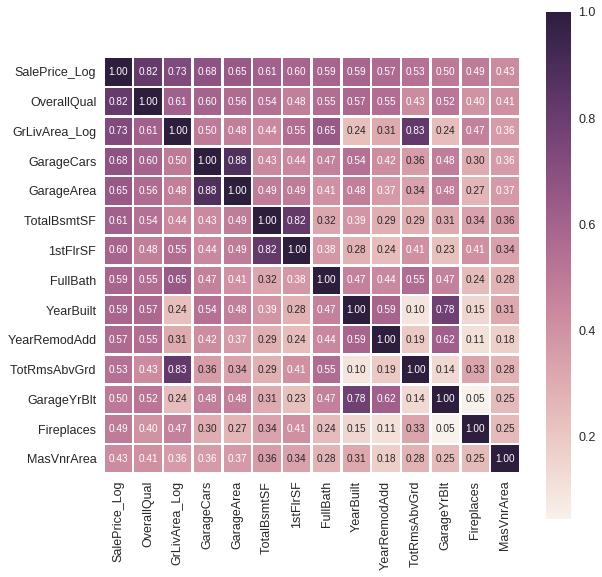

In [0]:
plot_corr_matrix(df_train, nr_feats, target)

In [0]:
id_test = df_test['Id']

to_drop_num  = cols_bel_corr_limit
to_drop_catg = catg_weak_corr

cols_to_drop = ['Id'] + to_drop_num + to_drop_catg 

for df in [df_train, df_test]:
    df.drop(cols_to_drop, inplace= True, axis = 1)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


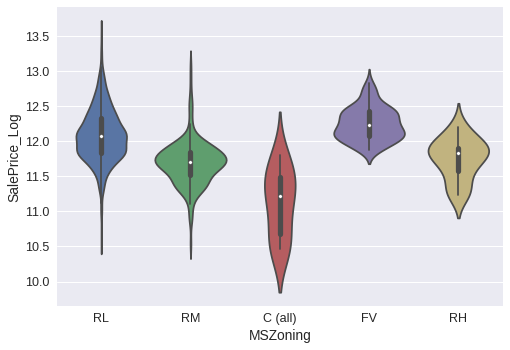

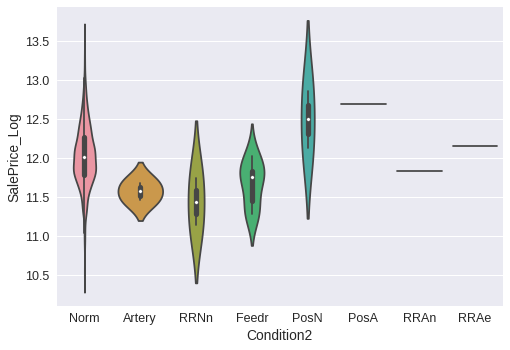

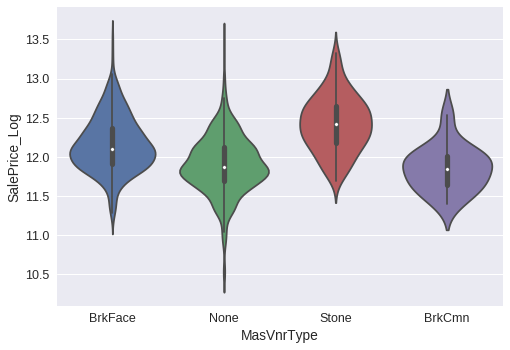

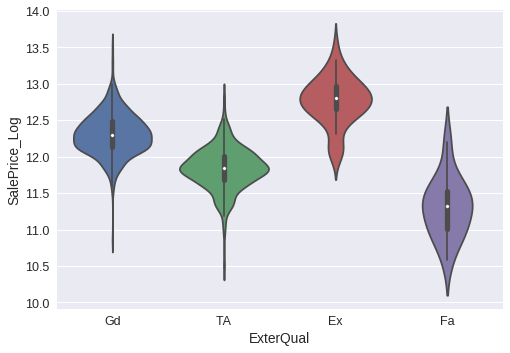

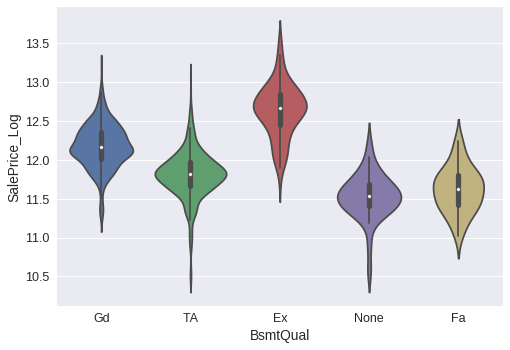

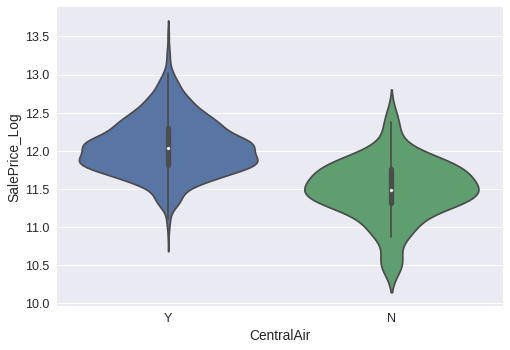

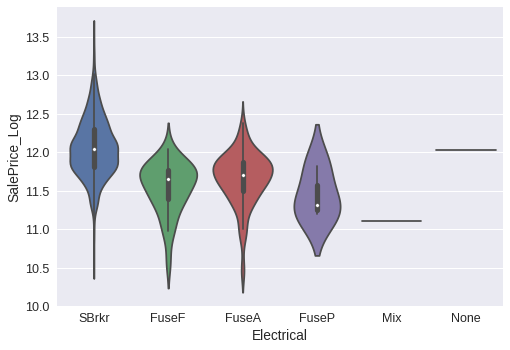

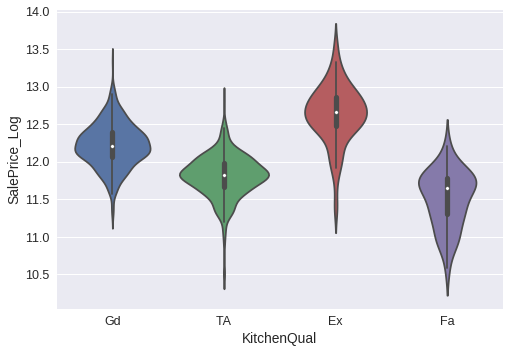

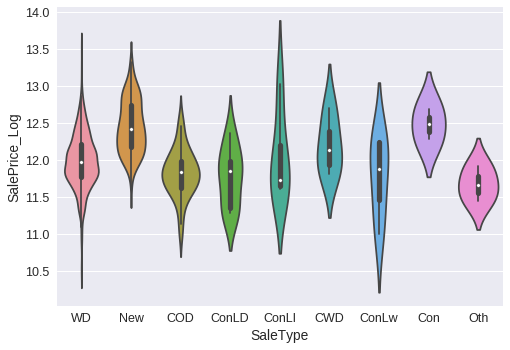

In [0]:
catg_list = catg_strong_corr.copy()
catg_list.remove('Neighborhood')

for catg in catg_list :
    #sns.catplot(x=catg, y=target, data=df_train, kind='boxen')
    sns.violinplot(x=catg, y=target, data=df_train)
    plt.show()
    #sns.boxenplot(x=catg, y=target, data=df_train)
    #bp = df_train.boxplot(column=[target], by=catg)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


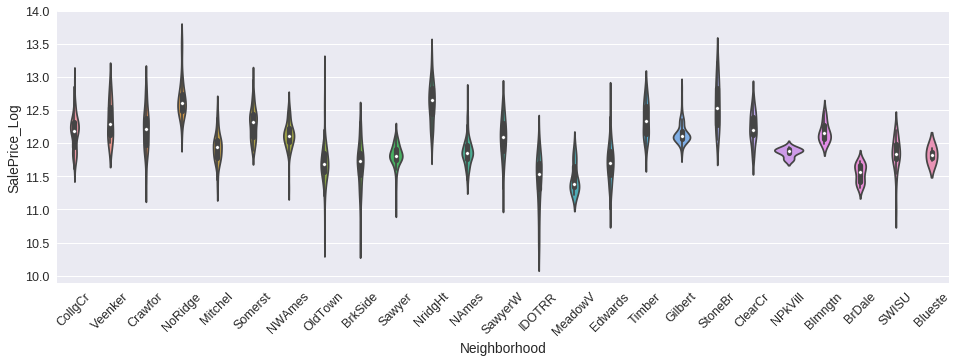

In [0]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 5)
sns.violinplot(x='Neighborhood', y=target, data=df_train, ax=ax)
plt.xticks(rotation=45)
plt.show()

In [0]:
for catg in catg_list :
    g = df_train.groupby(catg)[target].mean()
    print(g)

MSZoning
C (all)    11.118275
FV         12.246621
RH         11.749848
RL         12.085891
RM         11.692901
Name: SalePrice_Log, dtype: float64
Condition2
Artery    11.570046
Feedr     11.670639
Norm      12.025902
PosA      12.691584
PosN      12.493883
RRAe      12.154785
RRAn      11.827050
RRNn      11.435340
Name: SalePrice_Log, dtype: float64
MasVnrType
BrkCmn     11.853246
BrkFace    12.163635
None       11.896891
Stone      12.425142
Name: SalePrice_Log, dtype: float64
ExterQual
Ex    12.764047
Fa    11.304554
Gd    12.311287
TA    11.837993
Name: SalePrice_Log, dtype: float64
BsmtQual
Ex      12.640397
Fa      11.617609
Gd      12.179888
None    11.529691
TA      11.810863
Name: SalePrice_Log, dtype: float64
CentralAir
N    11.491869
Y    12.061096
Name: SalePrice_Log, dtype: float64
Electrical
FuseA    11.660324
FuseF    11.539635
FuseP    11.446820
Mix      11.112463
None     12.028745
SBrkr    12.061470
Name: SalePrice_Log, dtype: float64
KitchenQual
Ex    12.633617
F

In [0]:
# 'MSZoning'
msz_catg2 = ['RM', 'RH']
msz_catg3 = ['RL', 'FV'] 


# Neighborhood
nbhd_catg2 = ['Blmngtn', 'ClearCr', 'CollgCr', 'Crawfor', 'Gilbert', 'NWAmes', 'Somerst', 'Timber', 'Veenker']
nbhd_catg3 = ['NoRidge', 'NridgHt', 'StoneBr']

# Condition2
cond2_catg2 = ['Norm', 'RRAe']
cond2_catg3 = ['PosA', 'PosN'] 

# SaleType
SlTy_catg1 = ['Oth']
SlTy_catg3 = ['CWD']
SlTy_catg4 = ['New', 'Con']



In [0]:
for df in [df_train, df_test]:
    
    df['MSZ_num'] = 1  
    df.loc[(df['MSZoning'].isin(msz_catg2) ), 'MSZ_num'] = 2    
    df.loc[(df['MSZoning'].isin(msz_catg3) ), 'MSZ_num'] = 3        
    
    df['NbHd_num'] = 1       
    df.loc[(df['Neighborhood'].isin(nbhd_catg2) ), 'NbHd_num'] = 2    
    df.loc[(df['Neighborhood'].isin(nbhd_catg3) ), 'NbHd_num'] = 3    

    df['Cond2_num'] = 1       
    df.loc[(df['Condition2'].isin(cond2_catg2) ), 'Cond2_num'] = 2    
    df.loc[(df['Condition2'].isin(cond2_catg3) ), 'Cond2_num'] = 3    
    
    df['Mas_num'] = 1       
    df.loc[(df['MasVnrType'] == 'Stone' ), 'Mas_num'] = 2 
    
    df['ExtQ_num'] = 1       
    df.loc[(df['ExterQual'] == 'TA' ), 'ExtQ_num'] = 2     
    df.loc[(df['ExterQual'] == 'Gd' ), 'ExtQ_num'] = 3     
    df.loc[(df['ExterQual'] == 'Ex' ), 'ExtQ_num'] = 4     
   
    df['BsQ_num'] = 1          
    df.loc[(df['BsmtQual'] == 'Gd' ), 'BsQ_num'] = 2     
    df.loc[(df['BsmtQual'] == 'Ex' ), 'BsQ_num'] = 3     
 
    df['CA_num'] = 0          
    df.loc[(df['CentralAir'] == 'Y' ), 'CA_num'] = 1    

    df['Elc_num'] = 1       
    df.loc[(df['Electrical'] == 'SBrkr' ), 'Elc_num'] = 2 


    df['KiQ_num'] = 1       
    df.loc[(df['KitchenQual'] == 'TA' ), 'KiQ_num'] = 2     
    df.loc[(df['KitchenQual'] == 'Gd' ), 'KiQ_num'] = 3     
    df.loc[(df['KitchenQual'] == 'Ex' ), 'KiQ_num'] = 4      
    
    df['SlTy_num'] = 2       
    df.loc[(df['SaleType'].isin(SlTy_catg1) ), 'SlTy_num'] = 1  
    df.loc[(df['SaleType'].isin(SlTy_catg3) ), 'SlTy_num'] = 3  
    df.loc[(df['SaleType'].isin(SlTy_catg4) ), 'SlTy_num'] = 4  
  

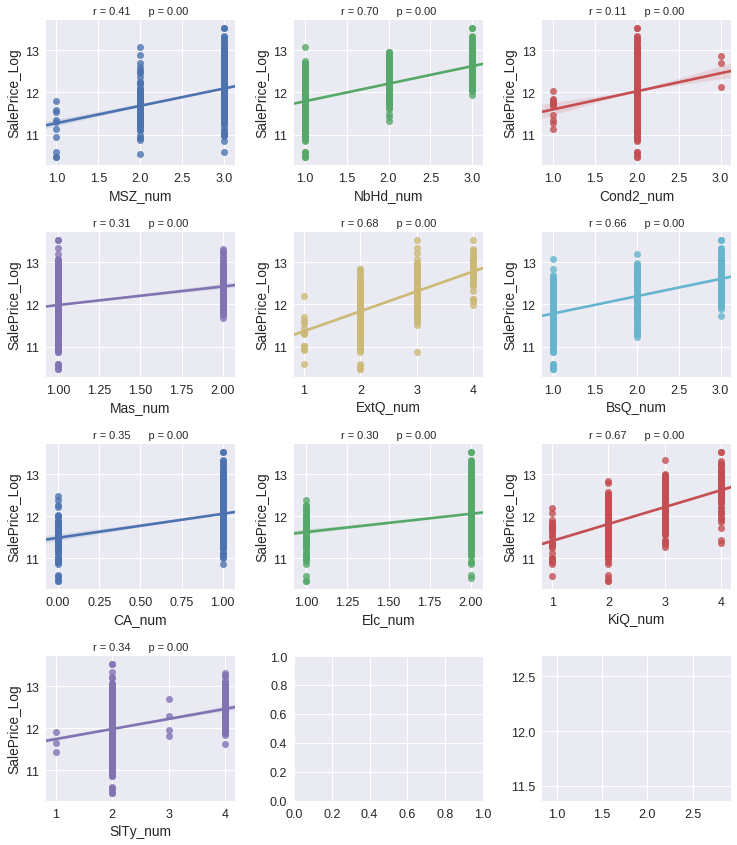

In [0]:
new_col_num = ['MSZ_num', 'NbHd_num', 'Cond2_num', 'Mas_num', 'ExtQ_num', 'BsQ_num', 'CA_num', 'Elc_num', 'KiQ_num', 'SlTy_num']

nr_rows = 4
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(new_col_num):
            sns.regplot(df_train[new_col_num[i]], df_train[target], ax = axs[r][c])
            stp = stats.pearsonr(df_train[new_col_num[i]], df_train[target])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show()  

In [0]:
catg_cols_to_drop = ['Neighborhood' , 'Condition2', 'MasVnrType', 'ExterQual', 'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType']

corr1 = df_train.corr()
corr_abs_1 = corr1.abs()

nr_all_cols = len(df_train)
ser_corr_1 = corr_abs_1.nlargest(nr_all_cols, target)[target]

print(ser_corr_1)
cols_bel_corr_limit_1 = list(ser_corr_1[ser_corr_1.values <= min_val_corr].index)


for df in [df_train, df_test] :
    df.drop(catg_cols_to_drop, inplace= True, axis = 1)
    df.drop(cols_bel_corr_limit_1, inplace= True, axis = 1)    

SalePrice_Log    1.000000
OverallQual      0.817185
GrLivArea_Log    0.730255
NbHd_num         0.696515
GarageCars       0.680625
ExtQ_num         0.678840
KiQ_num          0.667893
BsQ_num          0.659285
GarageArea       0.650888
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771
YearBuilt        0.586570
YearRemodAdd     0.565608
TotRmsAbvGrd     0.534422
GarageYrBlt      0.500449
Fireplaces       0.489450
MasVnrArea       0.429532
MSZ_num          0.409404
CA_num           0.351599
SlTy_num         0.335340
Mas_num          0.311370
Elc_num          0.304861
Cond2_num        0.105442
Name: SalePrice_Log, dtype: float64


In [0]:
corr2 = df_train.corr()
corr_abs_2 = corr2.abs()

nr_all_cols = len(df_train)
ser_corr_2 = corr_abs_2.nlargest(nr_all_cols, target)[target]

print(ser_corr_2)

SalePrice_Log    1.000000
OverallQual      0.817185
GrLivArea_Log    0.730255
NbHd_num         0.696515
GarageCars       0.680625
ExtQ_num         0.678840
KiQ_num          0.667893
BsQ_num          0.659285
GarageArea       0.650888
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771
YearBuilt        0.586570
YearRemodAdd     0.565608
TotRmsAbvGrd     0.534422
GarageYrBlt      0.500449
Fireplaces       0.489450
MasVnrArea       0.429532
MSZ_num          0.409404
Name: SalePrice_Log, dtype: float64


In [0]:
df_train.head()

,MSZoning,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,SalePrice_Log,GrLivArea_Log,MSZ_num,NbHd_num,ExtQ_num,BsQ_num,KiQ_num
0,RL,7,2003,2003,196.0,856,856,2,8,0,2003.0,2,548,12.247699,7.444249,3,2,3,2,3
1,RL,6,1976,1976,0.0,1262,1262,2,6,1,1976.0,2,460,12.109016,7.140453,3,2,2,2,2
2,RL,7,2001,2002,162.0,920,920,2,6,1,2001.0,2,608,12.317171,7.487734,3,2,3,2,3
3,RL,7,1915,1970,0.0,756,961,1,7,1,1998.0,3,642,11.849405,7.448334,3,2,2,1,3
4,RL,8,2000,2000,350.0,1145,1145,2,9,1,2000.0,3,836,12.429220,7.695303,3,3,3,2,3


In [0]:
df_test.head()

,MSZoning,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,GrLivArea_Log,MSZ_num,NbHd_num,ExtQ_num,BsQ_num,KiQ_num
0,RH,5,1961,1961,0.0,882.0,896,1,5,0,1961.0,1.0,730.0,6.797940,2,1,2,1,2
1,RL,6,1958,1958,108.0,1329.0,1329,1,6,0,1958.0,1.0,312.0,7.192182,3,1,2,1,3
2,RL,5,1997,1998,0.0,928.0,928,2,6,1,1997.0,2.0,482.0,7.395722,3,2,2,2,2
3,RL,6,1998,1998,20.0,926.0,926,2,7,1,1998.0,2.0,470.0,7.380256,3,2,2,1,3
4,RL,8,1992,1992,0.0,1280.0,1280,2,5,0,1992.0,2.0,506.0,7.154615,3,3,3,2,3


In [0]:
corr = df_train.corr()
corr_abs = corr.abs()

nr_all_cols = len(df_train)
print (corr_abs.nlargest(nr_all_cols, target)[target])

SalePrice_Log    1.000000
OverallQual      0.817185
GrLivArea_Log    0.730255
NbHd_num         0.696515
GarageCars       0.680625
ExtQ_num         0.678840
KiQ_num          0.667893
BsQ_num          0.659285
GarageArea       0.650888
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771
YearBuilt        0.586570
YearRemodAdd     0.565608
TotRmsAbvGrd     0.534422
GarageYrBlt      0.500449
Fireplaces       0.489450
MasVnrArea       0.429532
MSZ_num          0.409404
Name: SalePrice_Log, dtype: float64


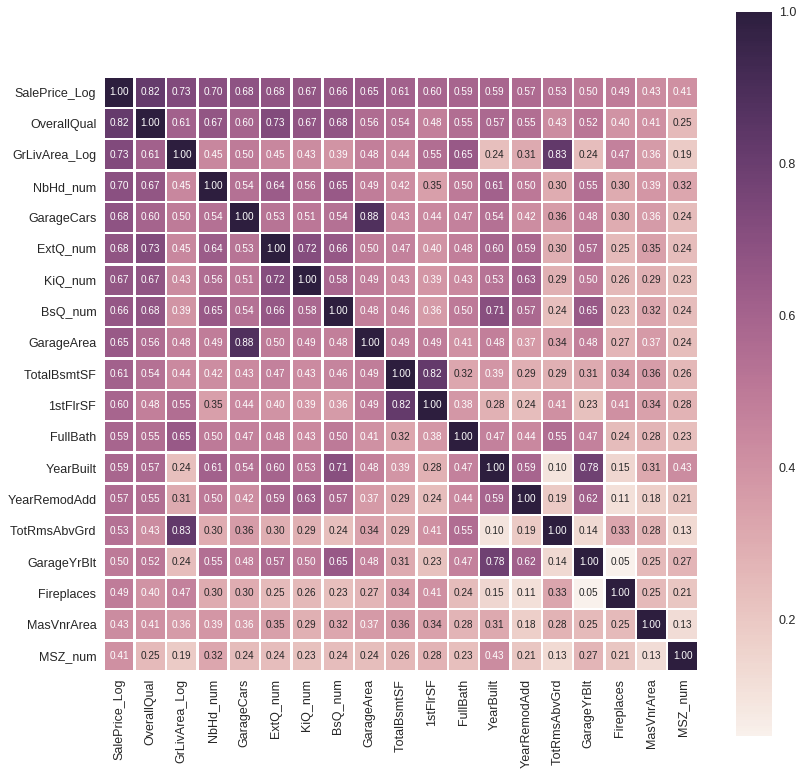

In [0]:
nr_feats=len(df_train.columns)
plot_corr_matrix(df_train, nr_feats, target)

In [0]:
cols = corr_abs.nlargest(nr_all_cols, target)[target].index
cols = list(cols)

if drop_similar == 1 :
    for col in ['GarageArea','1stFlrSF','TotRmsAbvGrd','GarageYrBlt'] :
        if col in cols: 
            cols.remove(col)

In [0]:
cols = list(cols)
print(cols)

['SalePrice_Log', 'OverallQual', 'GrLivArea_Log', 'NbHd_num', 'GarageCars', 'ExtQ_num', 'KiQ_num', 'BsQ_num', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'MasVnrArea', 'MSZ_num']


In [0]:
feats = cols.copy()
feats.remove('SalePrice_Log')

print(feats)

['OverallQual', 'GrLivArea_Log', 'NbHd_num', 'GarageCars', 'ExtQ_num', 'KiQ_num', 'BsQ_num', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'MasVnrArea', 'MSZ_num']
